# Classification On Mushroom Dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [156]:
train_path = 'Mushroom_datasets/mushroom_train.csv'
test_path = 'Mushroom_datasets/mushroom_test.csv'

In [157]:
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42748 entries, 0 to 42747
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   cap-diameter          42748 non-null  float64
 1   cap-shape             42748 non-null  object 
 2   cap-surface           42748 non-null  object 
 3   cap-color             42748 non-null  object 
 4   does-bruise-or-bleed  42748 non-null  object 
 5   gill-attachment       42748 non-null  object 
 6   gill-spacing          42748 non-null  object 
 7   gill-color            42748 non-null  object 
 8   stem-height           42748 non-null  float64
 9   stem-width            42748 non-null  float64
 10  stem-color            42748 non-null  object 
 11  has-ring              42748 non-null  object 
 12  ring-type             42748 non-null  object 
 13  habitat               42748 non-null  object 
 14  season                42748 non-null  object 
 15  class              

In [158]:
test_df

,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-color,has-ring,ring-type,habitat,season,class
0,13.95,s,e,g,f,d,c,w,7.67,22.22,w,f,f,d,a,e
1,17.79,s,k,n,f,d,c,y,6.39,36.42,n,f,f,d,u,p
2,1.50,x,k,n,f,a,c,n,5.30,1.44,n,f,f,d,w,p
3,15.33,x,t,n,t,d,c,b,5.16,26.60,n,f,f,g,a,p
4,15.96,p,y,w,f,a,c,w,23.57,19.51,n,t,m,m,a,e
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18316,7.26,x,i,n,f,a,c,n,7.96,7.95,n,t,z,g,a,p
18317,21.33,x,d,n,f,p,c,n,17.48,38.40,w,f,f,d,a,e
18318,2.65,s,y,n,f,a,d,p,8.49,3.78,n,f,f,h,u,e
18319,14.75,f,t,l,f,s,c,b,8.40,22.11,b,f,f,l,a,e


In [159]:
train_df

,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-color,has-ring,ring-type,habitat,season,class
0,4.98,c,i,y,f,a,c,n,6.04,6.21,w,f,f,d,a,p
1,2.84,x,y,y,f,a,c,w,5.66,3.55,y,t,r,h,u,p
2,11.44,x,y,y,f,a,c,w,7.03,25.29,n,t,e,d,w,e
3,8.77,s,t,r,t,d,c,g,4.44,13.61,r,f,f,d,a,p
4,7.55,x,d,n,t,p,c,y,8.41,18.44,y,f,f,d,a,e
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42743,3.28,f,y,p,f,e,c,n,4.96,3.51,w,t,e,m,u,p
42744,8.91,x,w,p,f,s,c,p,4.61,11.12,p,f,f,d,a,p
42745,45.84,o,y,y,f,p,c,y,5.75,26.36,n,f,f,d,s,e
42746,10.91,f,y,n,f,a,c,w,7.55,24.38,n,t,e,d,w,e


In [109]:
column_to_convert = ['cap-shape', 'cap-surface', 'cap-color', 'does-bruise-or-bleed', 'gill-attachment','gill-spacing', 'gill-color', 'stem-color', 'has-ring','ring-type', 'habitat', 'season']
for column_name in column_to_convert:
    color_dummies = pd.get_dummies(train_df[column_name], prefix=column_name)
    test_color_dummies = pd.get_dummies(test_df[column_name], prefix=column_name)
    # Concatenate the original DataFrame with the new one-hot encoded columns
    train_df = pd.concat([train_df.drop(column_name, axis=1), color_dummies], axis=1)
    test_df = pd.concat([test_df.drop(column_name, axis=1), test_color_dummies], axis=1)

In [110]:
train_df.info

<bound method DataFrame.info of        cap-diameter  stem-height  stem-width class  cap-shape_b  cap-shape_c  \
0              4.98         6.04        6.21     p            0            1   
1              2.84         5.66        3.55     p            0            0   
2             11.44         7.03       25.29     e            0            0   
3              8.77         4.44       13.61     p            0            0   
4              7.55         8.41       18.44     e            0            0   
...             ...          ...         ...   ...          ...          ...   
42743          3.28         4.96        3.51     p            0            0   
42744          8.91         4.61       11.12     p            0            0   
42745         45.84         5.75       26.36     e            0            0   
42746         10.91         7.55       24.38     e            0            0   
42747          2.41         3.52        3.71     p            0            0   

       

## First convert all the string object to integer mappings.
### To achieve this we can use pd.factorize().

In [111]:
class_mappings = {'p': 0, 'e': 1}
train_df['class'] = train_df['class'].map(class_mappings)
test_df['class'] = test_df['class'].map(class_mappings)

## Data inspection

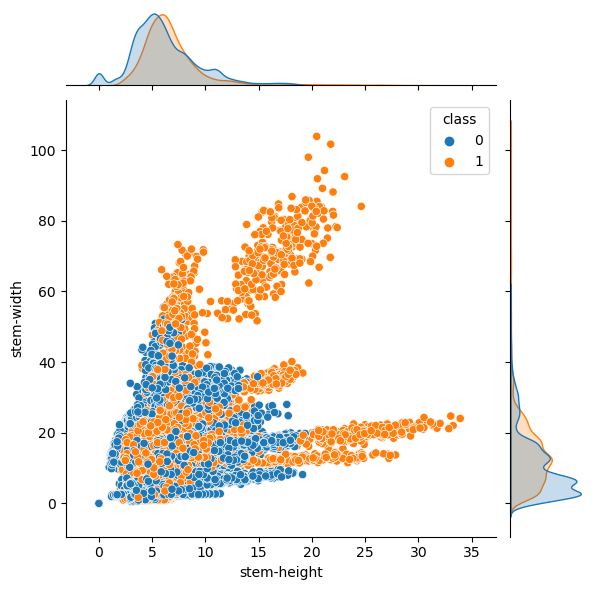

In [112]:
import seaborn as sns

sns.jointplot(x='stem-height', y='stem-width', data=train_df, hue='class')

<Axes: xlabel='cap-diameter', ylabel='Count'>

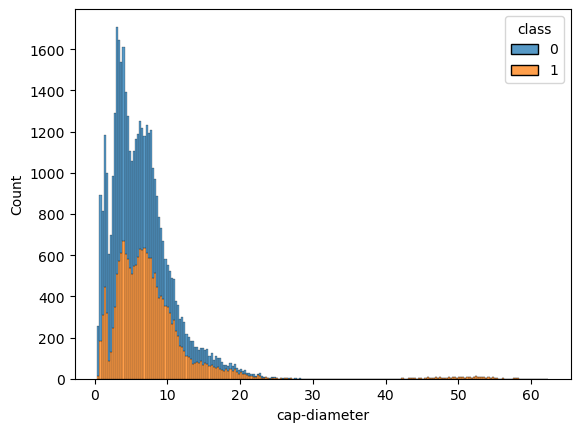

In [113]:
sns.histplot(data=train_df, x='cap-diameter', hue='class', multiple='stack')

## Let's create a trivial model that predict based on target class probability

In [ ]:
train_x = train_df.drop(['class'], axis=1).to_numpy().astype(np.float32)
train_y = train_df['class'].to_numpy().astype(np.float32)
test_x = test_df.drop(['class'], axis=1).to_numpy().astype(np.float32)
test_y = test_df['class'].to_numpy().astype(np.float32)
train_x.shape, train_y.shape

In [170]:
from sklearn.metrics import f1_score

class_0_count = train_df['class'].value_counts()[0]
class_1_count = train_df['class'].value_counts()[1]
print("Class 0 count:", class_0_count, "Class 1 count:", class_1_count)
def trivial_model(n_data):
    return np.random.rand(n_data) > (class_1_count/(class_0_count+class_1_count))

from sklearn.metrics import accuracy_score

n_data = test_y.shape[0]
trivial_pred = trivial_model(n_data)
print(f"Accuracy: {accuracy_score(test_y, trivial_pred):2f}")
print(f"Accuracy: {f1_score(test_y, trivial_pred):2f}")

Class 0 count: 23595 Class 1 count: 19153
Accuracy: 0.496916
Accuracy: 0.492540


## Let's create a base-line model that classify using nearest mean

In [171]:
from sklearn.neighbors import NearestCentroid

clf = NearestCentroid()
clf.fit(train_x, train_y)
pred_y = clf.predict(test_x)
print(f"Accuracy: {accuracy_score(test_y, pred_y):2f}")
print(f"Accuracy: {f1_score(test_y, pred_y):2f}")

Accuracy: 0.603461
Accuracy: 0.536464


## Generates train data and train labels.

In [114]:
train_data = train_df.drop(['class'], axis=1).to_numpy().astype(np.float32)
train_label = train_df['class'].to_numpy().astype(np.float32)
test_data = test_df.drop(['class'], axis=1).to_numpy().astype(np.float32)
test_label = test_df['class'].to_numpy().astype(np.float32)
train_data.shape, train_label.shape

((42748, 92), (42748,))

## Classification Using Neural Network.

In [115]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

# Define a custom dataset class
class myDataset(torch.utils.data.Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]
        return sample, label

train_data_torch = torch.from_numpy(train_data)
test_data_torch = torch.from_numpy(test_data)
n_class = 2
train_label_one_hot = np.eye(n_class)[train_label.astype(int)]
test_label_one_hot = np.eye(n_class)[test_label.astype(int)]
train_label_torch = torch.from_numpy(train_label_one_hot.astype(np.float32))
test_label_torch = torch.from_numpy(test_label_one_hot.astype(np.float32))
train_dataset = myDataset(train_data_torch, train_label_torch)
test_dataset = myDataset(test_data_torch, test_label_torch)

N, D = train_data_torch.shape
N, D

(42748, 92)

In [116]:
trainset, valset = torch.utils.data.random_split(train_dataset, [30000, N-30000])
print(f'Train set size: {len(trainset)}, Validation set size: {len(valset)}')

Train set size: 30000, Validation set size: 12748


In [117]:
# Define function to call for each training epoch (one complete pass over the training set)
def train(model, trainloader, criterion, optimizer, device):
    model.train() # set model to training mode
    running_loss = 0; running_acc = 0
    with tqdm(total=len(trainloader), desc=f"Train", unit="batch") as pbar:
        for n_batch, (train_data, labels) in enumerate(trainloader): # Iterate over batches
            train_data, labels = train_data.to(device), labels.to(device) # Move batch to device
            optimizer.zero_grad()
            output = model(train_data) # Forward pass
            loss = criterion(output, labels) # Compute loss
            loss.backward() # Backward pass
            optimizer.step() # Update weights
            running_loss += loss.item()
            running_acc += (output.argmax(1) == labels.argmax(1)).float().mean().item()
            pbar.set_postfix({'loss': loss.item(), 'acc': 100. * running_acc / (n_batch+1)})
            pbar.update() # Update progress bar
    return running_loss / len(trainloader), running_acc / len(trainloader) # return loss and accuracy for this epoch

In [118]:
# Define function to call for each validation epoch (one complete pass over the validation set)
def validate(model, valloader, criterion, device):
    model.eval() # set model to evaluation mode (e.g. turn off dropout, batchnorm, etc.)
    running_loss = 0; running_acc = 0
    with torch.no_grad(): # no need to compute gradients for validation
        with tqdm(total=len(valloader), desc=f"Eval", unit="batch") as pbar:
            for n_batch, (train_data, labels) in enumerate(valloader): # Iterate over batches
                train_data, labels = train_data.to(device), labels.to(device) # Move batch to device
                output = model(train_data) # Forward pass
                loss = criterion(output, labels) # Compute loss
                running_loss += loss.item()
                running_acc += (output.argmax(1) == labels.argmax(1)).float().mean().item()
                pbar.set_postfix({'loss': loss.item(), 'acc': 100. * running_acc / (n_batch+1)})
                pbar.update() # Update progress bar
    return running_loss / len(valloader), running_acc / len(valloader)  # return loss and accuracy for this epoch

In [119]:
# set the device to use and move model to device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
elif torch.torch.backends.mps.is_available():
    device = torch.device("mps") # MPS acceleration is available on MacOS 12.3+
else:
    device = torch.device("cpu")

print(f"Using device: {device}")


Using device: mps


In [120]:
class LinearRegression(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)
    
class MLP(nn.Module):
    def __init__(self, n_feature, n_classes, n_hidden): # Define layers in the constructor
        super().__init__()
        self.fc1 = nn.Linear(n_feature, n_hidden)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(n_hidden, n_classes)
        
    def forward(self, x): # Define forward pass in the forward method
        x = x.view(x.shape[0], -1)  #flatten into a 784 length tensor
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x # note: no softmax, as this is included in the loss function in PyTorch


In [162]:
batchsize = 200
n_feature = D
output_class = 2
n_hidden = 128
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=batchsize, shuffle=False)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batchsize, shuffle=False)

model = MLP(n_feature, output_class, n_hidden).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.02)

n_epoch = 10
best_acc = -1
train_loss_history = []; train_acc_history = []
val_loss_history = []; val_acc_history = []
for epoch in range(n_epoch):
    print(f"Epoch {epoch+1}/{n_epoch}")
    train_loss, train_acc = train(model, trainloader, criterion, optimizer, device)
    val_loss, val_acc     = validate(model, valloader, criterion, device)

    train_loss_history.append(train_loss); train_acc_history.append(train_acc)
    val_loss_history.append(val_loss); val_acc_history.append(val_acc)

Epoch 1/10


Eval: 100%|██████████| 64/64 [00:00<00:00, 292.22batch/s, loss=0.0709, acc=98.3]


Epoch 2/10


Eval: 100%|██████████| 64/64 [00:00<00:00, 263.80batch/s, loss=0.0112, acc=99.6] 


Epoch 3/10


Eval: 100%|██████████| 64/64 [00:00<00:00, 310.41batch/s, loss=0.011, acc=99.8]  


Epoch 4/10


Eval: 100%|██████████| 64/64 [00:00<00:00, 322.28batch/s, loss=0.017, acc=99.8]  


Epoch 5/10


Eval: 100%|██████████| 64/64 [00:00<00:00, 322.92batch/s, loss=0.0056, acc=99.8]  


Epoch 6/10


Eval: 100%|██████████| 64/64 [00:00<00:00, 318.65batch/s, loss=0.0719, acc=99.2] 


Epoch 7/10


Eval: 100%|██████████| 64/64 [00:00<00:00, 336.77batch/s, loss=0.00102, acc=99.9] 


Epoch 8/10


Eval: 100%|██████████| 64/64 [00:00<00:00, 330.54batch/s, loss=0.000817, acc=99.9]


Epoch 9/10


Eval: 100%|██████████| 64/64 [00:00<00:00, 330.10batch/s, loss=0.000271, acc=100]


Epoch 10/10


Eval: 100%|██████████| 64/64 [00:00<00:00, 312.64batch/s, loss=0.000281, acc=100]


In [164]:
from sklearn.metrics import f1_score


test_loss, test_acc = validate(model, testloader, criterion, device)
pred_y = model(test_data_torch.to(device)).argmax(1).cpu().numpy()
test_f1 = f1_score(test_label, pred_y, average='macro')
print(f"Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}, Test f1: {test_f1:.4f}")

Eval: 100%|██████████| 92/92 [00:00<00:00, 294.77batch/s, loss=0.000321, acc=100] 


Test loss: 0.0012, Test acc: 0.9996, Test f1: 0.9996


## Classification Using Gaussian Mixture Model

### Generates train data and train label for the gmm

In [123]:
train_x = train_df.drop(['class'], axis=1).to_numpy().astype(np.float32)
train_y = train_df['class'].to_numpy().astype(np.float32)
test_x = test_df.drop(['class'], axis=1).to_numpy().astype(np.float32)
test_y = test_df['class'].to_numpy().astype(np.float32)
train_x.shape, train_y.shape

((42748, 92), (42748,))

In [125]:
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [165]:
unique_classes = np.unique(train_y)
gmm_models = []

for cls in unique_classes:
    gmm = GaussianMixture(n_components=92, covariance_type='full', random_state=42)
    gmm.fit(train_x[train_y == cls])
    gmm_models.append(gmm)

In [166]:
def predict_gmm_class(X, gmm_models, unique_classes):
    scores = np.array([gmm.score_samples(X) for gmm in gmm_models]).T
    return unique_classes[np.argmax(scores, axis=1)]

y_pred_train = predict_gmm_class(train_x, gmm_models, unique_classes)
y_pred_test = predict_gmm_class(test_x, gmm_models, unique_classes)

In [167]:
train_accuracy = accuracy_score(train_y, y_pred_train)
test_accuracy = accuracy_score(test_y, y_pred_test)

print(f"Training accuracy: {train_accuracy:.2f}")
print(f"Testing accuracy: {test_accuracy:.2f}")
f1 = f1_score(test_y, y_pred_test, average='macro')
print(f"Test f1: {f1:.4f}")

Training accuracy: 1.00
Testing accuracy: 1.00
Test f1: 0.9961


## Classification Using SVM

In [168]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

c_values = np.logspace(-3, 3, num=7)
param_grid = {'C': c_values}

svm = SVC(kernel='linear', max_iter=100)
grid_search = GridSearchCV(svm, param_grid=param_grid, cv=5)
grid_search.fit(train_x, train_y)
y_pred = grid_search.predict(test_x)
accuracy = grid_search.score(test_x, test_y)
print(f"Accuracy: {accuracy:.2f}")
print(f"F1 score: {f1_score(test_y, y_pred, average='macro'):.4f}")

/Users/wangtianhe/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/wangtianhe/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/wangtianhe/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/wangtianhe/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/wangtianhe/anaconda3/lib/python3.10/site-packages/sklearn/svm/_ba

Accuracy: 0.62
F1 score: 0.5846


/Users/wangtianhe/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


## K nearest neighbor

In [169]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(train_x, train_y)
y_pred = knn.predict(train_x)
accuracy = accuracy_score(train_y, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(f"F1 score: {f1_score(train_y, y_pred, average='macro'):.4f}")

Accuracy: 1.00
F1 score: 0.9998
